<a href="https://colab.research.google.com/github/AchinthaThennakoon/L4S2-FYP-UOM/blob/main/proof%20/CNN_2024-07-10_pretrain_model/CNN_model_with_pretrain(4_diseases).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib

In [ ]:
import pandas as pd

In [ ]:
import pickle

In [ ]:
import json
import os

In [ ]:
import numpy as np

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# loading data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/proof/corn_plant_dataset'

In [ ]:
data_dir = pathlib.Path(dataset_path)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/FYP_code/proof/corn_plant_dataset')

In [ ]:
train_ds,val_ds =  keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="both",
    seed=123,
    batch_size=32,
    image_size=(224, 224),
    )

Found 3852 files belonging to 4 classes.
Using 2697 files for training.
Using 1155 files for validation.


In [ ]:
for batch in train_ds.take(1):
    images, labels = batch
    print(images.shape)  # Should be (32, 224, 224, 3) if batch size is 32
    print(labels.shape)

(32, 224, 224, 3)
(32,)


In [ ]:
class_names = train_ds.class_names
class_names

['Common_rust', 'Gray_leaf_spot', 'Northern_Leaf_Blight', 'healthy']

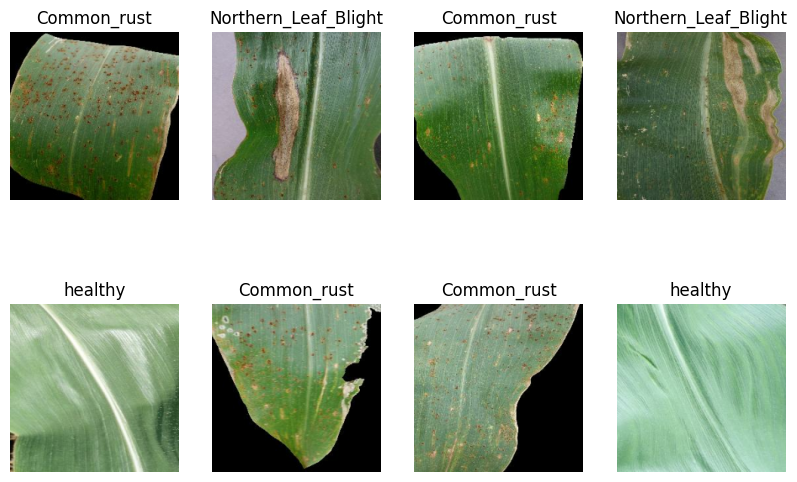

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## divide validation set to test & validation

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))


Number of validation batches: 37


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 3)
validation_dataset = val_ds.skip(val_batches // 3)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 25
Number of test batches: 12


# parameters and augmentations

In [ ]:
resize_and_rescale = keras.Sequential([
  keras.layers.Resizing(224, 224),
  keras.layers.Rescaling(1./127.5, offset=-1),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
no_of_classes = len(train_ds.class_names)
no_of_classes

4

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [ ]:
epochs = 150

# model

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= input_shape, pooling= 'max')

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  386


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
def create_model():
    inputs = layers.Input(shape=input_shape)
    x = resize_and_rescale(inputs)
    x = data_augmentation(x)
    x = base_model(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(no_of_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Early stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='val_loss',
                                                    mode='min',
                                                    patience=5,
                                                    restore_best_weights=True
                                                    )

# Training, Save and evaluation functions

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/proof/2024-07-10_prooving/models'

In [ ]:
model = create_model()
history = model.fit(
                    train_ds,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_dataset,
                    verbose=1,
                    epochs=epochs,
                    callbacks=[early_stopping]
                    )

model.save(os.path.join(model_path, f'model_depth_{4}.keras'))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                           

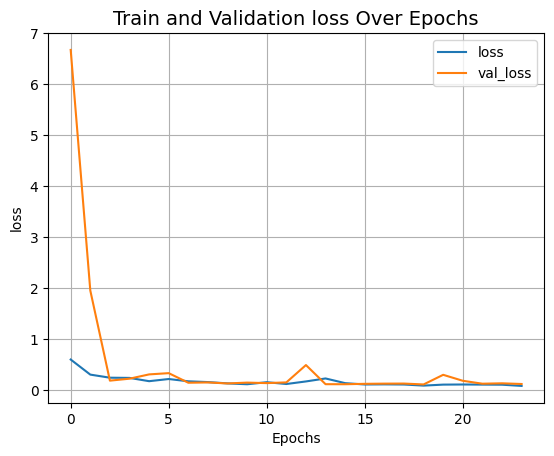

KeyError: 'top-5-accuracy'

In [ ]:
def plot_history(item):
      plt.plot(history.history[item], label=item)
      plt.plot(history.history["val_" + item], label="val_" + item)
      plt.xlabel("Epochs")
      plt.ylabel(item)
      plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
      plt.legend()
      plt.grid()
      plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

12/12 [==============================] - 2s 164ms/step - loss: 0.1013 - accuracy: 0.9557


In [ ]:
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Test accuracy: 0.9557291865348816
Test loss: 0.10125508904457092


# predictions

In [ ]:
predictions = model.predict(test_dataset)

12/12 [==============================] - 4s 118ms/step


In [ ]:
predictions

array([[1.2434592e-06, 1.3250682e-05, 7.4168988e-06, 9.9997807e-01],
       [1.5206557e-03, 8.3225000e-01, 1.6415559e-01, 2.0737590e-03],
       [3.6347238e-04, 1.2913570e-02, 4.5073219e-02, 9.4164979e-01],
       ...,
       [1.7445992e-03, 9.6926761e-01, 2.8325567e-02, 6.6222536e-04],
       [2.6555153e-04, 5.8315861e-01, 4.1545650e-01, 1.1193287e-03],
       [3.9918598e-04, 2.7484076e-02, 9.7201306e-01, 1.0374760e-04]],
      dtype=float32)

In [ ]:
y_pred_classes = np.argmax(predictions, axis=1)
y_pred_classes

array([3, 1, 3, 0, 3, 2, 2, 2, 2, 1, 2, 3, 1, 2, 2, 3, 3, 0, 3, 3, 2, 0,
       2, 0, 3, 0, 3, 2, 2, 2, 1, 3, 0, 2, 3, 0, 2, 2, 3, 3, 3, 3, 2, 1,
       2, 0, 3, 0, 2, 3, 3, 2, 2, 3, 3, 2, 0, 2, 3, 3, 0, 0, 2, 3, 3, 2,
       2, 0, 2, 0, 3, 1, 2, 1, 0, 1, 3, 3, 2, 2, 0, 2, 3, 2, 0, 2, 0, 0,
       3, 2, 0, 3, 2, 1, 2, 1, 0, 1, 1, 3, 0, 2, 3, 2, 0, 0, 3, 0, 3, 2,
       1, 0, 0, 1, 0, 0, 2, 2, 1, 3, 1, 0, 0, 1, 1, 2, 0, 1, 0, 2, 3, 2,
       0, 3, 3, 1, 2, 3, 0, 1, 1, 1, 0, 3, 2, 0, 3, 0, 2, 3, 0, 3, 0, 0,
       1, 2, 3, 3, 2, 3, 3, 3, 3, 3, 1, 0, 0, 2, 3, 2, 0, 3, 3, 0, 3, 1,
       2, 0, 0, 2, 3, 2, 0, 0, 3, 0, 2, 2, 3, 3, 2, 3, 3, 2, 2, 1, 2, 0,
       3, 2, 0, 1, 0, 0, 2, 2, 3, 2, 3, 0, 1, 1, 1, 1, 2, 2, 2, 3, 0, 2,
       3, 0, 2, 0, 2, 0, 3, 3, 2, 0, 3, 0, 1, 2, 0, 3, 2, 1, 2, 1, 2, 0,
       0, 3, 3, 1, 3, 0, 2, 2, 3, 3, 2, 0, 3, 1, 1, 1, 2, 0, 1, 2, 2, 2,
       1, 0, 0, 0, 3, 2, 2, 0, 1, 2, 0, 3, 3, 0, 0, 0, 3, 2, 2, 3, 0, 2,
       2, 2, 3, 3, 0, 2, 1, 2, 2, 3, 2, 0, 0, 0, 2,

In [ ]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true

array([3, 1, 3, 0, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 0, 3, 3, 2, 0,
       2, 0, 3, 0, 3, 2, 2, 2, 2, 3, 0, 2, 3, 0, 2, 2, 3, 3, 3, 3, 2, 1,
       2, 0, 3, 0, 2, 3, 3, 2, 2, 3, 3, 2, 0, 2, 3, 3, 0, 0, 2, 3, 3, 2,
       2, 0, 2, 0, 3, 1, 2, 1, 0, 1, 3, 3, 2, 2, 0, 2, 3, 2, 0, 2, 0, 0,
       3, 2, 0, 3, 1, 1, 2, 1, 0, 1, 1, 3, 0, 2, 3, 2, 0, 0, 3, 0, 3, 2,
       1, 0, 0, 1, 0, 0, 2, 2, 2, 3, 1, 0, 0, 1, 1, 2, 0, 1, 0, 2, 3, 2,
       0, 3, 3, 2, 2, 3, 0, 1, 2, 1, 0, 3, 2, 0, 3, 0, 2, 3, 0, 3, 0, 0,
       1, 2, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 0, 2, 3, 2, 0, 3, 3, 0, 3, 2,
       2, 0, 0, 2, 3, 2, 0, 0, 3, 0, 1, 2, 3, 3, 2, 3, 3, 1, 2, 1, 2, 0,
       3, 2, 0, 1, 0, 0, 2, 2, 3, 2, 3, 0, 1, 1, 1, 1, 2, 2, 2, 3, 0, 2,
       3, 0, 1, 0, 2, 0, 3, 3, 2, 0, 3, 0, 1, 2, 0, 3, 2, 1, 2, 1, 2, 0,
       0, 3, 3, 1, 3, 0, 2, 2, 3, 3, 2, 0, 3, 1, 1, 1, 2, 0, 1, 2, 2, 2,
       1, 0, 0, 0, 3, 2, 2, 0, 1, 2, 0, 3, 3, 0, 0, 0, 3, 2, 2, 3, 0, 2,
       2, 2, 3, 3, 0, 2, 2, 2, 2, 3, 2, 0, 0, 0, 2,

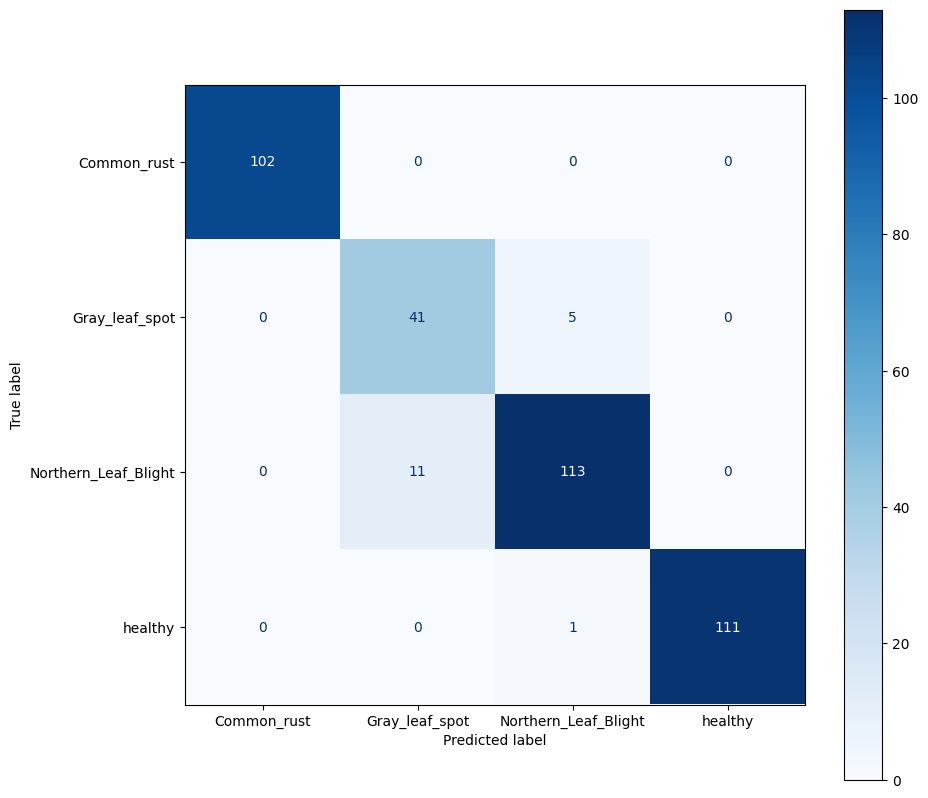

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()